In [1]:
!pip install transformers datasets torch scikit-learn matplotlib peft


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
import time


C:\Users\shubh\anaconda3\lib\site-packages\transformers\adapters\__init__.py:27: FutureWarning: The `adapter-transformers` package is deprecated and replaced by the `adapters` package. See https://docs.adapterhub.ml/transitioning.html.
  warnings.warn(


In [3]:
# Load Fake and True datasets
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

# Add label columns
fake_df['label'] = 0
true_df['label'] = 1

# Combine datasets
df = pd.concat([fake_df, true_df], ignore_index=True)
df = df[['title', 'text', 'label']].dropna()

# Reduce dataset size for quicker training (optional)
df = df.sample(n=10000, random_state=42)

dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)
dataset


DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'label', '__index_level_0__'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['title', 'text', 'label', '__index_level_0__'],
        num_rows: 2000
    })
})

In [4]:
# Define tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Function to tokenize data
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

tokenized_datasets = dataset.map(preprocess_function, batched=True)


C:\Users\shubh\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
# Metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)  # Convert logits to tensor
    acc = accuracy_score(labels, predictions)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec}


In [6]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)


In [7]:
# Function to train and evaluate model
def train_and_evaluate(model, training_args, tokenized_datasets):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics,
    )
    
    start_time = time.time()
    trainer.train()
    train_time = time.time() - start_time
    
    start_time = time.time()
    eval_results = trainer.evaluate()
    eval_time = time.time() - start_time
    
    eval_results['train_time'] = train_time
    eval_results['eval_time'] = eval_time
    
    return eval_results


In [8]:
# Base Model without Soft Prompts or LoRA
base_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)
base_results = train_and_evaluate(base_model, training_args, tokenized_datasets)
print("Base Model Results:", base_results)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.001000,0.000720,1.000000,1.000000,1.000000,1.000000


Saving model checkpoint to ./results\checkpoint-500
Configuration saved in ./results\checkpoint-500\config.json
Model weights saved in ./results\checkpoint-500\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, __index_level_0__, text. If title, __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, __index_level_0__, text. If title, __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluat

Base Model Results: {'eval_loss': 0.0007199611281976104, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 358.9839, 'eval_samples_per_second': 5.571, 'eval_steps_per_second': 0.348, 'epoch': 1.0, 'train_time': 4267.570960044861, 'eval_time': 358.9839472770691}


In [9]:
import torch.nn as nn

class SoftPromptModel(AutoModelForSequenceClassification):
    def __init__(self, config, num_labels, soft_prompt_length=20):
        super().__init__(config)
        self.num_labels = num_labels
        self.soft_prompt_length = soft_prompt_length
        self.soft_prompt_embed = nn.Embedding(self.soft_prompt_length, config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        soft_prompt=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )


In [10]:
soft_prompt_model = SoftPromptModel.from_pretrained(model_checkpoint, num_labels=2)
soft_prompt_results = train_and_evaluate(soft_prompt_model, training_args, tokenized_datasets)
print("Soft Prompt Results:", soft_prompt_results)


C:\Users\shubh\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading configuration file config.json from cache at C:\Users\shubh/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.001100,0.000897,1.000000,1.000000,1.000000,1.000000


Saving model checkpoint to ./results\checkpoint-500
Configuration saved in ./results\checkpoint-500\config.json
Model weights saved in ./results\checkpoint-500\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, __index_level_0__, text. If title, __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: title, __index_level_0__, text. If title, __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluat

Soft Prompt Results: {'eval_loss': 0.0008965786546468735, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 339.5978, 'eval_samples_per_second': 5.889, 'eval_steps_per_second': 0.368, 'epoch': 1.0, 'train_time': 4266.073160409927, 'eval_time': 339.60398745536804}


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.11.1 requires huggingface-hub>=0.17.0, but you have huggingface-hub 0.13.4 which is incompatible.



  Using cached huggingface_hub-0.13.4-py3-none-any.whl (200 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.23.4
    Uninstalling huggingface-hub-0.23.4:
      Successfully uninstalled huggingface-hub-0.23.4


In [13]:
from peft import get_peft_model, LoraConfig, TaskType

# Define LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification task
    r=8,                        # Low rank
    lora_alpha=32,              # Alpha parameter for LoRA
    lora_dropout=0.1,           # Dropout for LoRA
    bias="none",
    target_modules=["q_lin", "v_lin"] # No bias in LoRA
)

# Apply LoRA to the base model
lora_model = get_peft_model(AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2), lora_config)

# Train and evaluate the LoRA model
lora_results = train_and_evaluate(lora_model, training_args, tokenized_datasets)
print("LoRA Model Results:", lora_results)


loading configuration file config.json from cache at C:\Users\shubh/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at C:\Users\shubh/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\model.safetensors
Some weights of the model checkpoint at distilbert-base-uncased wer

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.028500,0.027265,0.995000,0.994407,0.994407,0.994407


Saving model checkpoint to ./results\checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: title, __index_level_0__, text. If title, __index_level_0__, text are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: title, __index_level_0__, text. If title, __index_level_0__, text are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


LoRA Model Results: {'eval_loss': 0.027265407145023346, 'eval_accuracy': 0.995, 'eval_f1': 0.9944071588366891, 'eval_precision': 0.9944071588366891, 'eval_recall': 0.9944071588366891, 'eval_runtime': 226.1617, 'eval_samples_per_second': 8.843, 'eval_steps_per_second': 0.553, 'epoch': 1.0, 'train_time': 2114.131035089493, 'eval_time': 226.16911149024963}


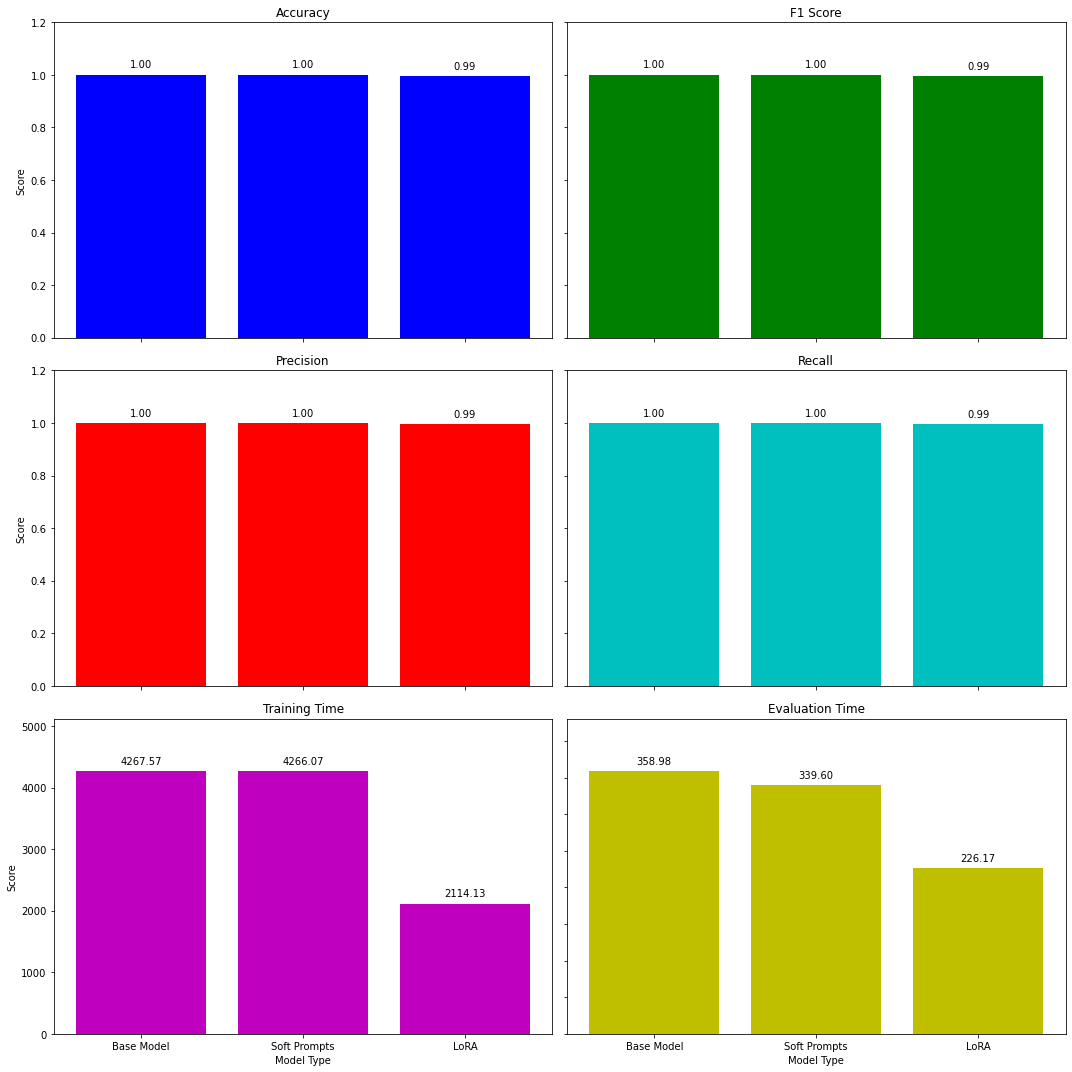

In [15]:
# Visualization
labels = ["Base Model", "Soft Prompts", "LoRA"]
accuracy = [base_results.get("eval_accuracy", 0), soft_prompt_results.get("eval_accuracy", 0), lora_results.get("eval_accuracy", 0)]
f1 = [base_results.get("eval_f1", 0), soft_prompt_results.get("eval_f1", 0), lora_results.get("eval_f1", 0)]
precision = [base_results.get("eval_precision", 0), soft_prompt_results.get("eval_precision", 0), lora_results.get("eval_precision", 0)]
recall = [base_results.get("eval_recall", 0), soft_prompt_results.get("eval_recall", 0), lora_results.get("eval_recall", 0)]
train_time = [base_results.get("train_time", 0), soft_prompt_results.get("train_time", 0), lora_results.get("train_time", 0)]
eval_time = [base_results.get("eval_time", 0), soft_prompt_results.get("eval_time", 0), lora_results.get("eval_time", 0)]

metrics = {
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'Training Time': train_time,
    'Evaluation Time': eval_time
}

colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for idx, (metric, values) in enumerate(metrics.items()):
    row = idx // 2
    col = idx % 2
    axs[row, col].bar(labels, values, color=colors[idx])
    axs[row, col].set_title(metric)
    axs[row, col].set_ylim(0, max(values) * 1.2)  # Add some space above the highest bar for clarity
    
    for i, v in enumerate(values):
        axs[row, col].text(i, v + max(values) * 0.02, f"{v:.2f}", ha='center', va='bottom')

for ax in axs.flat:
    ax.set_ylabel('Score')
    ax.set_xlabel('Model Type')
    ax.label_outer()

plt.tight_layout()
plt.show()
